In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-prediction-2020/sampleSubmission.csv
/kaggle/input/customer-churn-prediction-2020/train.csv
/kaggle/input/customer-churn-prediction-2020/test.csv


In [3]:
# import libraries to work with data frame and visualize 
import seaborn as sns
import matplotlib.pyplot as plt 
import os

# Import library for oversampling our minority class
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

# Install packages and import modules for model building and evaluating 
!pip install scikit-learn

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

ERROR: Could not find a version that satisfies the requirement imblearn (from versions: none)
ERROR: No matching distribution found for imblearn


In [4]:
df = pd.read_csv('/kaggle/input/customer-churn-prediction-2020/train.csv')
df_test = pd.read_csv('/kaggle/input/customer-churn-prediction-2020/test.csv')
df.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [5]:
#Get a basic info about data frame, explore data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

Data frame have 20 columns, 5 of them are object type, so we have to transform them to category type, as model can perform on data with object type. Data frame has 4250 rows, as we can see, there is no missing values.

In [7]:
# check for duplicated data 
df.duplicated().sum()

0

Data Frame also don't have duplicated data

In [8]:
# Get statistics
df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


The data provides insights into customer usage patterns and behavior, including their call durations, charges, and interactions with customer service. It suggests that most customers have similar usage patterns across different time periods (daytime, evening, nighttime), with a relatively low number of international calls and customer service interactions.

In [10]:
# Transform column area_code to dummy variables
area_code_dummies = pd.get_dummies(df['area_code'], dtype='int')
state_dummies = pd.get_dummies(df['state'], dtype='int')

In [11]:
# Change variables Yes/No to 1/0 
rep = {'no': 0,
       'yes':1}
df['international_plan'] = 	df['international_plan'].replace(rep).astype(int)
df['voice_mail_plan'] = df['voice_mail_plan'].replace(rep).astype(int)
df['churn'] = df['churn'].replace(rep).astype(int)
df.dtypes

/tmp/ipykernel_34/855903739.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['international_plan'] = 	df['international_plan'].replace(rep).astype(int)
/tmp/ipykernel_34/855903739.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['voice_mail_plan'] = df['voice_mail_plan'].replace(rep).astype(int)
/tmp/ipykernel_34/855903739.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in

state                             object
account_length                     int64
area_code                         object
international_plan                 int64
voice_mail_plan                    int64
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                              int64
dtype: object

In [12]:
# Look for class balance in our data frame
df['churn'].value_counts(normalize = True)
print(df['churn'].unique())
df.head(5)

[0 1]


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In data frame we have 86% of our current customers, and 14% of churn. That's quite big imbalance, but still model can give accuracy of 90%, but it will be based on good predictive capability of customers who are in majority. 

In [13]:
# Replace columns object type with dummy variables.
df = df.drop(columns = ['state', 'area_code'])
df1 = pd.concat([df, area_code_dummies], axis='columns')
df2 = pd.concat([df1, state_dummies], axis='columns')
df2

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,0,0,0,0,0,0,0,0,0,0
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,0,0,0,0,0,0,0,0,0,0
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,0,0,0,0,0,0,0,0,0,0
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,0,0,0,0,0,0,0,0,0,0
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,0,0,0,188.3,70,32.01,243.8,88,20.72,...,0,0,0,0,0,0,0,0,0,0
4246,73,0,0,0,177.9,89,30.24,131.2,82,11.15,...,0,0,0,0,0,0,0,0,1,0
4247,75,0,0,0,170.7,101,29.02,193.1,126,16.41,...,0,0,0,0,0,0,0,0,0,0
4248,50,0,1,40,235.7,127,40.07,223.0,126,18.96,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#Assing X and y variables and then 

X = df2.drop(columns=['churn']) 
y = df2['churn'] 

churned = X[y == 1]
not_churned = X[y == 0]

In [16]:
# Oversample our churned customers 
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(pd.concat([churned, not_churned]), pd.concat([y[y == 1], y[y == 0]]))

In [21]:
# Check shape of our sets 
X_resampled.shape
y_resampled.value_counts()

(7304, 71)

In [22]:
# Split our data for train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size = 0.25, random_state = 42)
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print("Size of training set:", train_size)
print("Size of testing set:", test_size)

Size of training set: 5478
Size of testing set: 1826


In [24]:
# Building model and fitting sets 
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)
dt_pred = decision_tree.predict(X_test)

In [25]:
# Model evaluation 
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.961
Precision: 0.927
Recall: 1.000
F1 Score: 0.962


Accuracy — This metric measures the proportion of correct predictions made by the model across the entire dataset. It is calculated as the ratio of true positives (TP) and true negatives (TN) to the total number of samples.

Precision — Precision measures the proportion of true positive predictions among all positive predictions made by the model. It is calculated as the ratio of TP to the sum of TP and false positives (FP).

Recall — Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions among all actual positive instances. It is calculated as the ratio of TP to the sum of TP and false negatives (FN).

F1 Score — F1 Score is a metric that balances precision and recall. It is calculated as the harmonic mean of precision and recall. F1 Score is useful when seeking a balance between high precision and high recall, as it penalizes extreme negative values of either component. [https://klu.ai/glossary/accuracy-precision-recall-f1]

<Figure size 400x400 with 0 Axes>

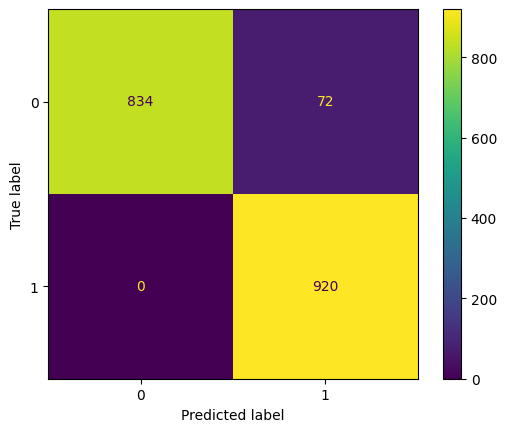

In [26]:
#Buiding confusion matrix to see, where model performed well and where performed bad
cm = confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
plt.figure(figsize = (4,4))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = decision_tree.classes_)
disp.plot()

With confusion matrix we can see, that model performed very well, among 1826 labels it mistakenly classificated only 72 labels as False Positive ( type 1 error). But actually for business this is not that bad, because they will pay more attention to clients, so maybe this clients in future would become more loyal to the company.

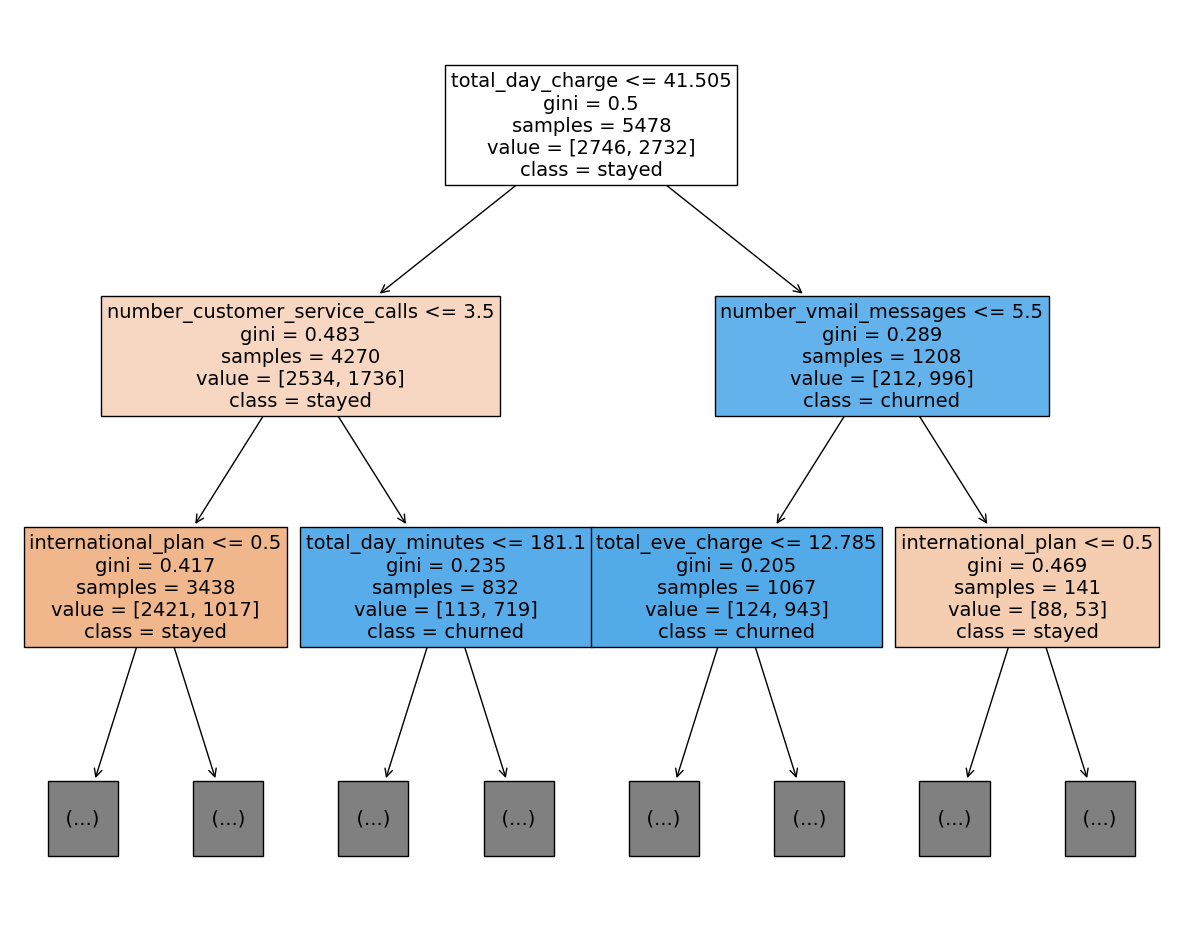

In [27]:
# Visualizing tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

In [28]:
# Create table with features that mostly affects target variable 
feat_dict= {}
for col, val in sorted(zip(X_train.columns, decision_tree.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()}).iloc[:20]
feat_df

,Feature,Importance
0,number_customer_service_calls,0.165593
1,international_plan,0.149308
2,total_day_charge,0.137694
3,total_eve_minutes,0.073101
4,total_day_minutes,0.072118
5,total_intl_minutes,0.063825
6,total_eve_charge,0.051394
7,number_vmail_messages,0.042077
8,total_intl_calls,0.039367
9,total_eve_calls,0.030757


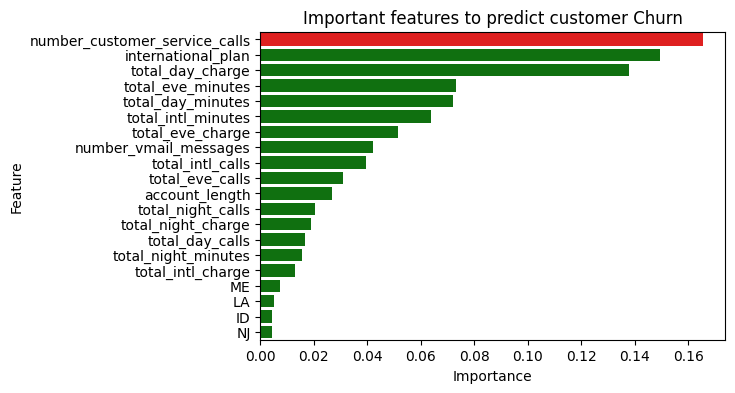

In [42]:
# Visualize feature importance 
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(6,4))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict customer Churn')
plt.show()

From this plot we can see, that most important features, that has the bigger impact on will customer stay or churn are 'number_customer_service_calls', 'international_plan', 'total_day_charge', 'total eve and day minutes'.

In [30]:
#Explore test dataset 
df_test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [31]:
# Make the same transformation as we did to our train df
rep = {'no': 0,
       'yes':1}
df_test['international_plan'] = df['international_plan'].replace(rep).astype(int)
df_test['voice_mail_plan'] = df['voice_mail_plan'].replace(rep).astype(int)

df_test.dtypes

id                                 int64
state                             object
account_length                     int64
area_code                         object
international_plan                 int64
voice_mail_plan                    int64
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
dtype: object

In [32]:
# Hot -encoding, dropping columns 
area_code_dummies = pd.get_dummies(df_test['area_code'], dtype='int')
state_dummies = pd.get_dummies(df_test['state'], dtype='int')

id_column = df_test['id']
df_test = df_test.drop(columns = ['state', 'area_code', 'id'])
df_test1 = pd.concat([df_test, area_code_dummies], axis='columns')
df_test2 = pd.concat([df_test1, state_dummies], axis='columns')
df_test2

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,0,0,0,0,0,0,0,0,0,0
1,118,0,0,0,223.4,98,37.98,220.6,101,18.75,...,0,0,0,0,0,0,0,0,0,0
2,62,1,0,0,120.7,70,20.52,307.2,76,26.11,...,0,0,0,0,0,0,0,0,0,0
3,93,1,0,0,190.7,114,32.42,218.2,111,18.55,...,0,0,0,0,0,1,0,0,0,0
4,174,0,1,0,124.3,76,21.13,277.1,112,23.55,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,130,0,0,0,119.4,99,20.30,226.3,97,19.24,...,0,0,0,0,0,0,0,0,0,0
746,73,0,0,0,177.2,118,30.12,270.5,84,22.99,...,0,0,0,0,0,0,1,0,0,0
747,152,0,1,0,184.2,90,31.31,256.8,73,21.83,...,0,0,0,0,0,0,0,0,1,0
748,61,1,0,0,140.6,89,23.90,172.8,128,14.69,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Predicting target variable based on our model
y_predict_test_df = decision_tree.predict(df_test2)
y_predict_test_df 

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [37]:
# Concatenating results with id column 
result_df = pd.DataFrame({'ID': id_column , 'Predicted_Label': y_predict_test_df})

In [40]:
#Changing labels 
rep = {0 : 'no',
       1 : 'yes'}
result_df['Predicted_Label'] = result_df['Predicted_Label'].replace(rep)
result_df['Predicted_Label'].value_counts()

Predicted_Label
no     615
yes    135
Name: count, dtype: int64

In [ ]:
# Save our table to csv file 
result_df.to_csv("~/Downloads/Submission.csv")